# Testing PMT with chamber windows blocked

- Hamamatsu R375 PMT
- SRS445A amplifier @125x amplification & @500 Ohm input impedance
- SRS HV PSU
- 5 MHz low pass filter
- NI PXIe-5171 Oscilloscope

Lights are turned of in lab.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import simps

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_data(fname):
    with h5py.File(fname) as f:
        datasets = f['wfm_group0']
        scale_coef = datasets['axes']['axis1']['scale_coef']
        y = datasets['axes']['axis1']['data_vector']['data'].value*scale_coef[1]
        x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*4e-9
    return x,y

In [3]:
def quick_analyze(fname):
    with h5py.File(fname) as f:
        datasets = f['wfm_group0']
        scale_coef = datasets['axes']['axis1']['scale_coef']
        y = datasets['axes']['axis1']['data_vector']['data'].value*scale_coef[1]
        x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*4e-9
        
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(x,y)
    ax.set_xlabel('[s]')
    ax.set_ylabel('[V]')
    ax.set_title(fname.split('/')[-1].strip('.hws'))
    print('mean signal : {0:.2e} V'.format(y.mean()))
    print('ptp signal : {0:.2e} V'.format(y.ptp()))

mean signal : -5.27e-04 V
ptp signal : 2.62e-01 V


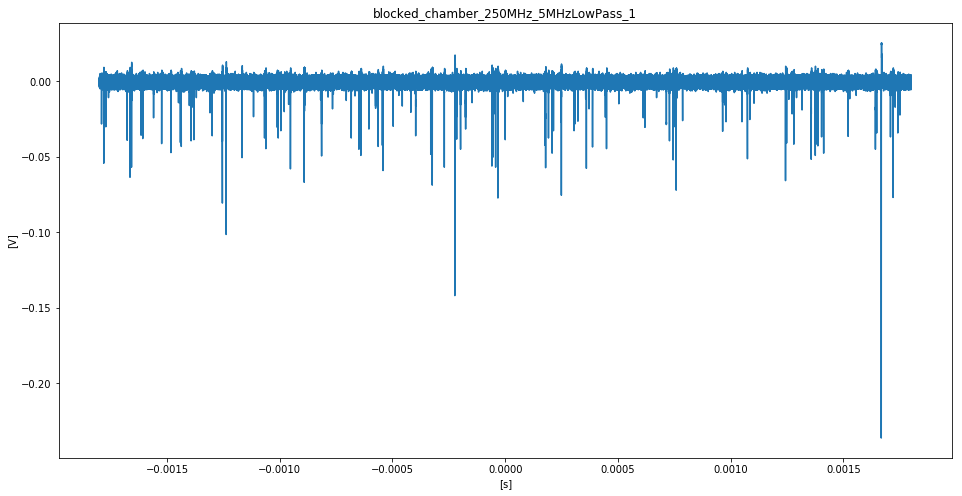

In [4]:
data_loc = "Data/2018_12_20/"
fname = "blocked_chamber_250MHz_5MHzLowPass_1.hws"
quick_analyze(data_loc+fname)

In [5]:
x,y = load_data(data_loc+fname)

In [6]:
peakLocs, peakInfo = find_peaks(abs(y), height = 1.2e-2, distance = 800, width = 20)
print(len(peakLocs))

113


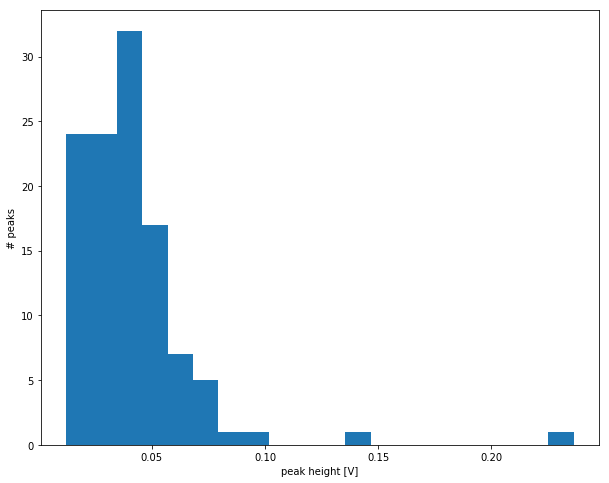

In [7]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(peakInfo['peak_heights'], bins = 20);
ax.set_xlabel("peak height [V]")
ax.set_ylabel("# peaks");

left : -5.58e-02 us; right : 7.73e-02 us; fwhm : 1.33e-01 us


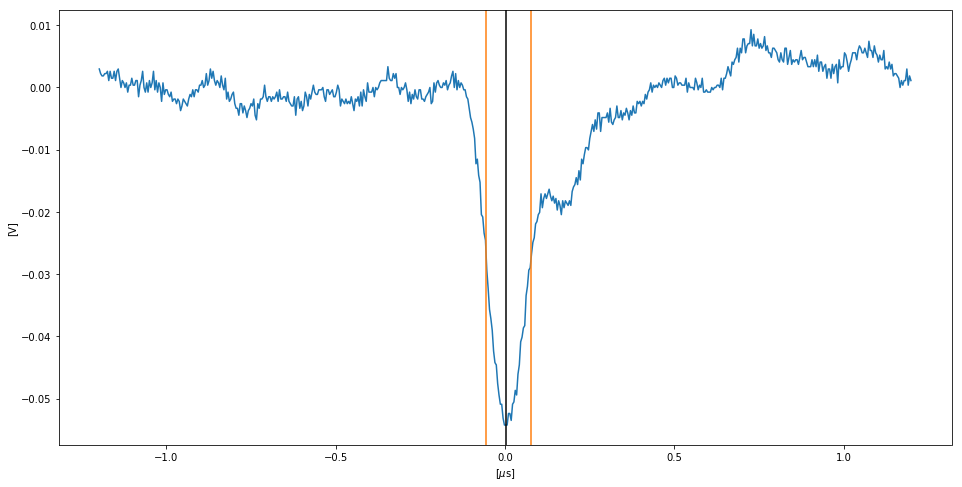

In [40]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq

peakID = 1
width = 300
start, stop = peakLocs[peakID]-width, peakLocs[peakID]+width

xx = (x[start:stop]-x[start:stop].mean())*1e6
yy = y[start:stop]
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(xx, yy)
ax.axvline((x[peakLocs[peakID]]-x[start:stop].mean())*1e6, color = 'black')
ax.set_ylabel('[V]')
ax.set_xlabel(r'[$\mu$s]')

intp = interp1d(xx,yy)
half_max = lambda x: yy.min()/2
intersect = lambda x: intp(x)-half_max(x)
left = brentq(intersect, xx.min(), 0)
right = brentq(intersect, 0, xx.max())
print('left : {0:.2e} us; right : {1:.2e} us; fwhm : {2:.2e} us'.format(left, right, right-left))

ax.axvline(left, color = 'C1')
ax.axvline(right, color = 'C1')

In [41]:
len(xx)

600

Text(0.5,0,'[$\\mu$s]')

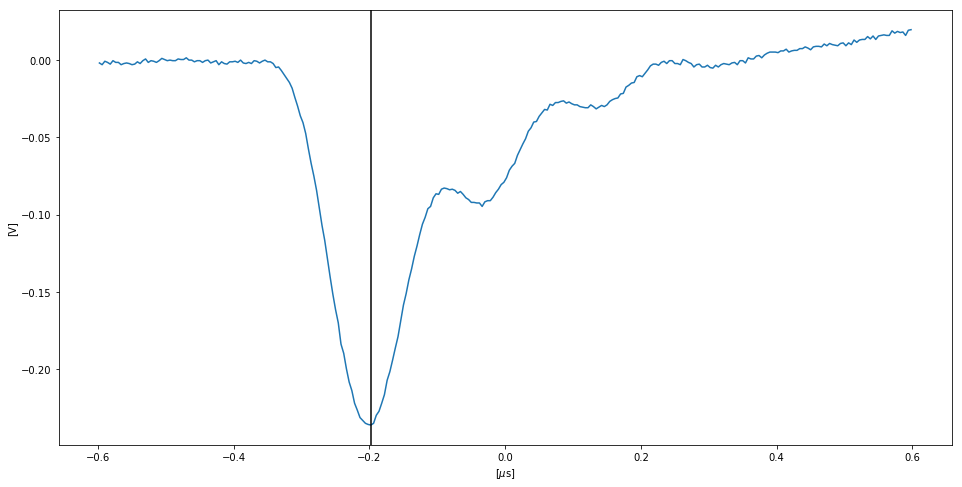

In [24]:
peakID = np.argmax(peakInfo['peak_heights'])
width = 200
start, stop = peakLocs[peakID]-width//2, peakLocs[peakID]+width
fig, ax = plt.subplots(figsize = (16,8))
ax.plot((x[start:stop]-x[start:stop].mean())*1e6, y[start:stop])
ax.axvline((x[peakLocs[peakID]]-x[start:stop].mean())*1e6, color = 'black')
ax.set_ylabel('[V]')
ax.set_xlabel(r'[$\mu$s]')

In [10]:
width = 400
integrationResults = []
for peakLoc in peakLocs:
    start, stop = peakLoc-width, peakLoc+width
    dx = 4e-9
    integrationResults.append(simps(y[start:stop],dx=dx))

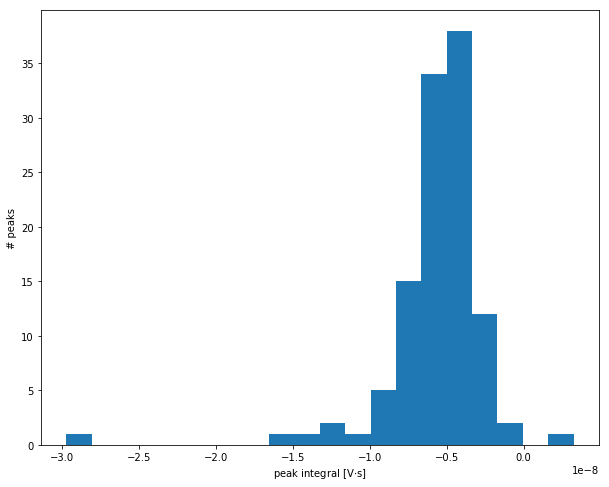

In [11]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(integrationResults, bins = 20)
ax.set_xlabel('peak integral [V$\cdot$s]')
ax.set_ylabel('# peaks');

In [12]:
import os
fnames = [fname for fname in os.listdir(data_loc) if fname[:7] == 'blocked']
fnames

['blocked_chamber_250MHz_5MHzLowPass_1.hws',
 'blocked_chamber_250MHz_5MHzLowPass_2.hws',
 'blocked_chamber_250MHz_5MHzLowPass_3.hws',
 'blocked_chamber_250MHz_5MHzLowPass_4.hws',
 'blocked_chamber_250MHz_5MHzLowPass_5.hws',
 'blocked_chamber_250MHz_5MHzLowPass_6.hws',
 'blocked_chamber_250MHz_5MHzLowPass_7.hws',
 'blocked_chamber_250MHz_5MHzLowPass_8.hws',
 'blocked_chamber_250MHz_5MHzLowPass_9.hws']

In [13]:
width = 400

def integrate_peaks(fname):
    x,y = load_data(fname)
    peakLocs, peakInfo = find_peaks(abs(y), height = 1.2e-2, distance = 800, width = 20)
    integrationResults = []
    for peakLoc in peakLocs:
        start, stop = peakLoc-width, peakLoc+width
        dx = 4e-9
        integrationResults.append(simps(y[start:stop],dx=dx))
    return peakLocs, peakInfo, integrationResults

In [14]:
results = {fname: integrate_peaks(data_loc+fname) for fname in fnames}
peakHeights = np.concatenate([results[fname][1]['peak_heights'] for fname in fnames]).ravel()
peakIntegrals = np.concatenate([results[fname][2] for fname in fnames]).ravel()

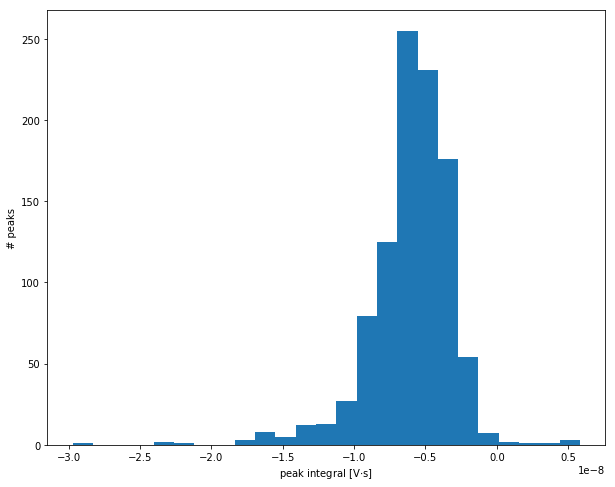

In [15]:
fig, ax = plt.subplots(figsize = (10,8))
hist = ax.hist(peakIntegrals, bins = 25)
ax.set_xlabel('peak integral [V$\cdot$s]')
ax.set_ylabel('# peaks');

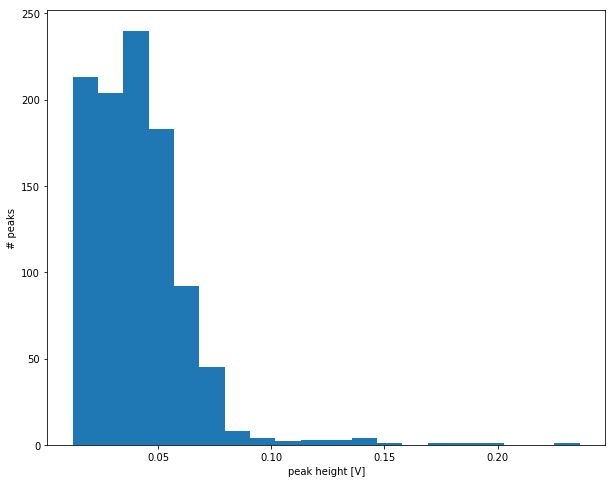

In [18]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(peakHeights, bins = 20);
ax.set_xlabel("peak height [V]")
ax.set_ylabel("# peaks");